In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import json
import os
import sys
sys.path.append("../lib")
from dataUtils import *
import cPickle as pickle
import cv2
from collections import Counter
from scipy.interpolate import UnivariateSpline


In [2]:
popular_color_features = "../Logs/vine_features_ordered.csv"
unpopular_color_features = "../Logs/unpopular_vine_features_ordered.csv"

In [28]:
def readFeatureFile(color_features):
    with open(color_features) as g:
        featureLines = g.readlines()
    print len(featureLines)
    return featureLines
    
def readFeatures(lines):
    ids = []
    features = []
    feats = []
    
    components = lines[0].strip().split(',')
    ID = components[0].strip().split('_')[0]
    
    for line in lines:
        components = line.strip().split('|')
        postId = components[0].strip().split('_')[0]
        if postId != ID:
            ids.append(postId)
            ID = postId
            #Take median of all frames in a vine for all the attributes
            median = np.median(feats,0)
            for i in range(len(median)):
                if np.isnan(median[i]):
                    median[i] = 0.0
            features.append(median)
            feats[:] = []
            feats.append([float(x) for x in components[1:]]) 
        else :
            feats.append([float(x) for x in components[1:]]) 
            
    return features, ids
    

In [29]:
pop_features = readFeatureFile(popular_color_features)
unpop_features = readFeatureFile(unpopular_color_features)

50187
5367


In [30]:
popfeatures_matrix , popposts = readFeatures(pop_features)

In [31]:
unpopfeatures_matrix , unpopposts = readFeatures(unpop_features)

In [32]:
print len(unpopfeatures_matrix) , len(unpopposts)

2939 2939


In [33]:
unpop_aes_features = np.asarray(unpopfeatures_matrix)
pop_aes_features = np.asarray(popfeatures_matrix)

In [34]:
samples = np.random.choice(pop_aes_features.shape[0], unpop_aes_features.shape[0])
sampledpop_aes_features = pop_aes_features[samples,:]


In [48]:
print sampledpop_aes_features.shape , unpop_aes_features.shape

(2939, 19) (2939, 19)


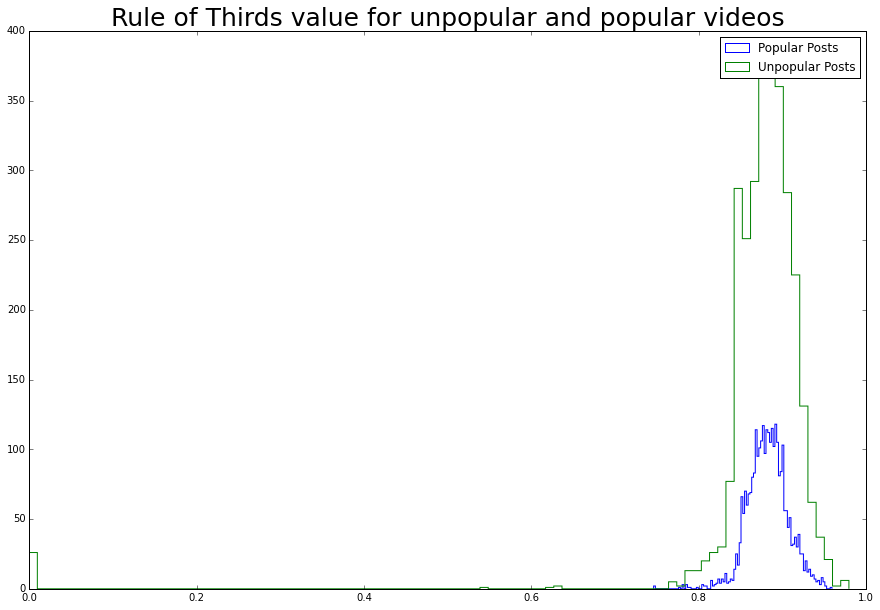

In [50]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.hist(sampledpop_aes_features[:,7], 100, normed=0,histtype='step', cumulative=False, linewidth = 1.0)
plt.hist(unpop_aes_features[:,7], 100, normed=0,histtype='step', cumulative=False, linewidth = 1.0)
plt.legend(['Popular Posts', 'Unpopular Posts'])
plt.title('Rule of Thirds distribution for unpopular and popular videos', fontsize = 25)
plt.show()

In [51]:
print np.mean(sampledpop_aes_features[:,7]) , np.var(sampledpop_aes_features[:,7])
print np.mean(unpop_aes_features[:,7]) , np.var(unpop_aes_features[:,7])

0.882534231191 0.000566538786058
0.874083208073 0.00779457560564


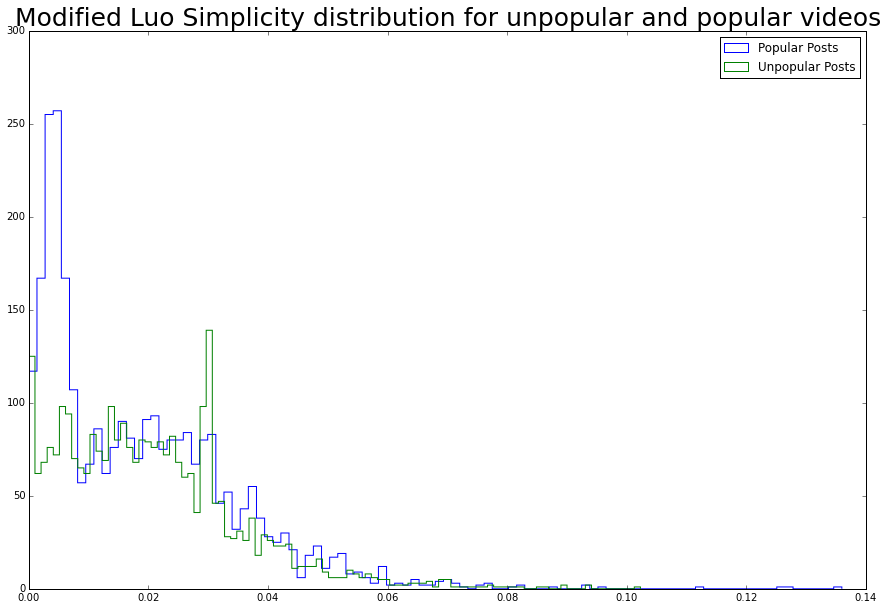

In [55]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.hist(sampledpop_aes_features[:,4], 100, normed=0,histtype='step', cumulative=False, linewidth = 1.0)
plt.hist(unpop_aes_features[:,4], 100, normed=0,histtype='step', cumulative=False, linewidth = 1.0)
plt.legend(['Popular Posts', 'Unpopular Posts'])
plt.title('Modified Luo Simplicity distribution for unpopular and popular videos', fontsize = 25)
plt.show()

In [57]:
print np.mean(sampledpop_aes_features[:,4]) , np.median(sampledpop_aes_features[:,4])
print np.mean(unpop_aes_features[:,4]) , np.median(unpop_aes_features[:,4])

0.0186410795551 0.015625
0.020702776109 0.01904296875


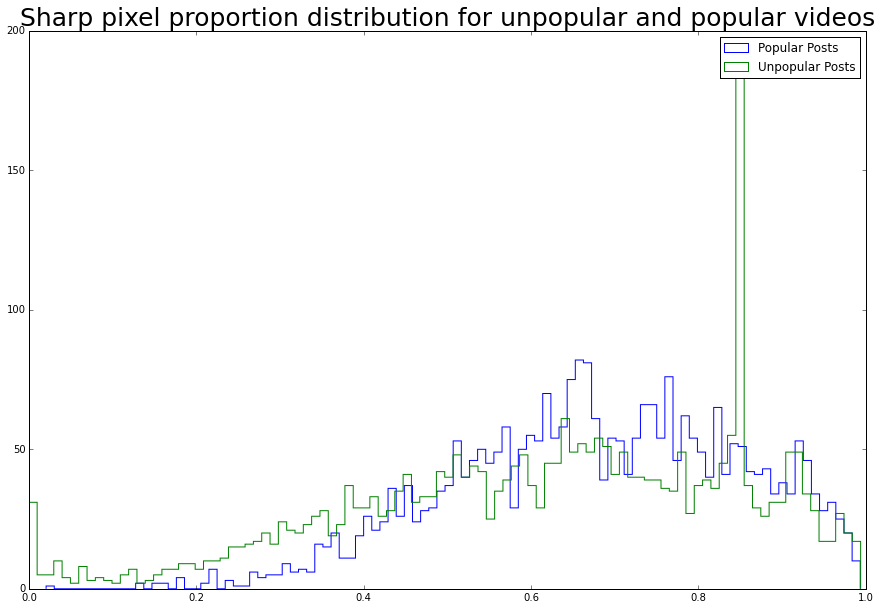

In [62]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.hist(sampledpop_aes_features[:,16], 100, normed=0,histtype='step', cumulative=False, linewidth = 1.0)
plt.hist(unpop_aes_features[:,16], 100, normed=0,histtype='step', cumulative=False, linewidth = 1.0)
plt.legend(['Popular Posts', 'Unpopular Posts'])
plt.title('Sharp pixel proportion distribution for unpopular and popular videos', fontsize = 25)
plt.show()

In [63]:
print np.mean(sampledpop_aes_features[:,16]) , np.median(sampledpop_aes_features[:,16])
print np.mean(unpop_aes_features[:,16]) , np.median(unpop_aes_features[:,16])

0.676991158836 0.677782118056
0.619541751516 0.645785590278
